Total Classes Detected: 10
Importing Classes .......
0 1 2 3 4 5 6 7 8 9  
Total Images in Images List =  10160
Total IDS in classNo List=  10160
(10160, 32, 32, 3)
(6502, 32, 32, 3)
(2032, 32, 32, 3)
(1626, 32, 32, 3)
[644, 617, 636, 641, 676, 647, 660, 665, 668, 648]


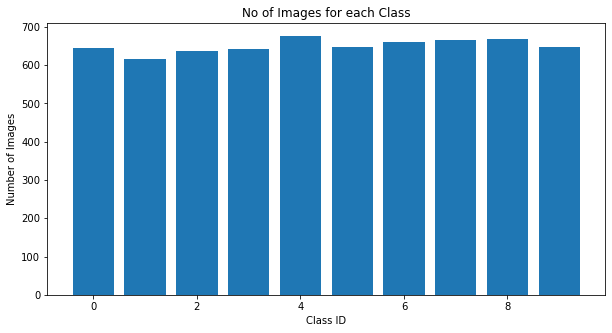

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

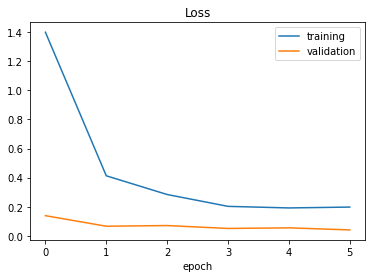

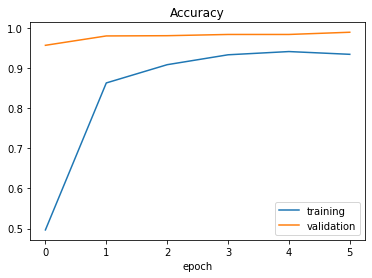

Test Score =  0.04038003832101822
Test Accuracy = 0.9881889820098877
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:/Users/Jadiel Santos/Desktop/FURB/Python TF/model\assets


In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
 
################ Parametros ########################
path = "C:/Users/Jadiel Santos/Desktop/FURB/Python TF/myData"
testRatio = 0.2
valRatio = 0.2
imageDimensions= (32,32,3)
batchSizeVal= 50
epochsVal = 6
stepsPerEpochVal = 120
####################################################

# Importa imagens dos arquivos
count = 0
images = []  # Lista contendo todas as imagens
classNo = [] # Lista contendo todos os ids de classes das imagens
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
print("Importing Classes .......")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))
 
# Converte para um numpy array 
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)
 
# Divide os dados (test/train)
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

# Exibe grafico de barra mostrando a distribuição das imagens
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)
 
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

# Função para preprocessar as imagens para treinamento 
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img
# img = preProcessing(X_train[30])
# img = cv2.resize(img,(300,300))
# cv2.imshow("PreProcesssed",img)
# cv2.waitKey(0)
 
X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))
 
 
# Reajusta as imagens
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
 
# Aumento da imagem
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
 
# Cria o model 
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500
 
    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                      imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(noOfNodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
 
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
 
model = myModel()
print(model.summary())
 
# Inicia processo de treinamento
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 steps_per_epoch=stepsPerEpochVal,
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)
 
# Exibe resultados 
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()
 
# Avalia imagens de teste
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])
 
# Salva o model treinado 
model.save("C:/Users/Jadiel Santos/Desktop/FURB/Python TF/model")


In [1]:
import numpy as np
import cv2
import pickle
from tensorflow import keras
 
########### Parametros ##############
width = 640
height = 480
threshold = 0.3 # Probabilidade minima para classificar
cameraNo = 0
#####################################
 
# Cria objeto da camera
cap = cv2.VideoCapture(cameraNo)
cap.set(3,width)
cap.set(4,height)
 
# Carrega model terinado 
model = keras.models.load_model("C:/Users/Jadiel Santos/Desktop/FURB/Python TF/model")
 
# Função de preprocessamento
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img
 
while True:
    success, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img,(32,32))
    img = preProcessing(img)
    cv2.imshow("Processsed Image",img)
    img = img.reshape(1,32,32,1)
    # Predicao
    classIndex = int(model.predict_classes(img))
    #print(classIndex)
    predictions = model.predict(img)
    #print(predictions)
    probVal= np.amax(predictions)
    print(classIndex, probVal)
 
    if probVal > threshold:
        cv2.putText(imgOriginal, str(classIndex) + "   "+ str(probVal),
                    (50,50),cv2.FONT_HERSHEY_COMPLEX,
                    1,(0,0,255),1)
 
    cv2.imshow("Original Image",imgOriginal)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
4 0.17720391
2 0.45283172
2 0.45148084
2 0.4366236
2 0.44502258
2 0.44512677
2 0.4448328
2 0.4443788
2 0.42536017
2 0.41454634
2 0.41222987
2 0.40921792
2 0.4237841
2 0.42696974
2 0.41889337
2 0.3958502
2 0.43464056
2 0.43158948
2 0.4110138
2 0.4160787
2 0.4114821
2 0.41945222
2 0.42735445
2 0.4091084
2 0.41270256
2 0.4034801
2 0.45207402
2 0.47940663
2 0.47848004
2 0.48049122
2 0.46841532
2 0.45714536
2 0.47298712
2 0.4873763
2 0.46954635
2 0.48650882
2 0.46354592
2 0.4824183
2 0.47438973
2 0.47439873
2 0.49444178
2 0.49055374
2 0.49524742
2 0.4778754
2 0.47995025
2 0.4969418
2 0.49231815
2 0.47866753
2 0.49717823
2 0.5037221
2 0.49258563
2 0.47553086
2 0.4

2 0.42101595
2 0.2920565
2 0.39668998
2 0.3585094
2 0.3070532
2 0.48686522
9 0.20745121
2 0.42838165
2 0.46518275
2 0.46494272
2 0.46208876
2 0.4774309
2 0.4566788
2 0.47559774
2 0.46494162
2 0.45799896
2 0.47265056
2 0.48605812
2 0.4634563
2 0.48579022
2 0.47364125
2 0.4809027
2 0.4553185
2 0.46588433
2 0.4720177
2 0.45134306
2 0.47066218
2 0.44958332
2 0.46141505
2 0.47216058
2 0.4634263
2 0.44701773
2 0.4732258
2 0.4466648
2 0.46829224
2 0.45467633
2 0.50754917
2 0.52688265
2 0.4819355
2 0.47819158
2 0.47364643
2 0.4792386
2 0.4817075


KeyboardInterrupt: 